In [113]:
# importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import os
import requests
import IPython.display as display
import PIL.Image

from cv2 import cvtColor
from cv2 import imread
from cv2 import COLOR_BGR2RGB

from keras import Model

In [114]:
def load_image(path):

    img = imread(path)
    img = cvtColor(img, COLOR_BGR2RGB)
    img = img / 255.

    return (img)

# defining function for converting from tensor to image (for using during visualization of the generated image)
def tensor_to_image(tensor):
  tensor = tensor*255
  arr = np.array(tensor, dtype=np.uint8)
  arr = arr[0]
  return PIL.Image.fromarray(arr)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [115]:
def display_pictures(content_img, style_img):

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].imshow(content_img)
    ax[0].title.set_text(f'Content Image {content_img.shape}')
    ax[0].axis('off')

    ax[1].imshow(style_img)
    ax[1].title.set_text(f'Style Image {style_img.shape}')
    ax[1].axis('off')


In [116]:
def load_vgg19():
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    return vgg

In [117]:
def create_list_of_vgg_layer():

    content_layer_name  = ['block5_conv2']

    style_layer_names   = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

    num_style_layers    = len(style_layer_names)

    return content_layer_name, style_layer_names, num_style_layers

In [118]:
def create_multi_output_model(vgg19, style_layers, content_layers):

    layers_name = style_layers + content_layers
    layers_output = list()
    for name in layers_name:
        layer = vgg19.get_layer(name)
        output = layer.output
        layers_output.append(output)

    multi_output_model = Model([vgg19.input], layers_output)
    multi_output_model.trainable = False

    return multi_output_model

In [119]:
def gram_matrix(input_tensor):

  Gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape   = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) #

  Gram_Normalized = Gram/num_locations
  return (Gram_Normalized)

In [120]:
def preprocessing_img(img):
    img = img * 255
    preprocessed_img = tf.keras.applications.vgg19.preprocess_input(img)
    return preprocessed_img

In [121]:
def compute_content_loss(content_generated, content_target):
    content_loss = tf.reduce_mean((content_generated - content_target)**2)
    return (content_loss)

def compute_style_loss(style_generated, style_target):

    all_style_loss = list()

    for generated, target in zip(style_generated, style_target):

        style_layer_loss = tf.reduce_mean((generated - target)**2)
        all_style_loss.append(style_layer_loss)

    num_style_layers = len(all_style_loss)
    style_loss = tf.add_n(all_style_loss) / num_style_layers

    return (style_loss)

def compute_total_loss(style_generated,
                       content_generated,
                       style_target,
                       content_target,
                       style_weight,
                       content_weight):

        content_loss = compute_content_loss(content_generated, content_target)
        style_loss = compute_style_loss(style_generated, style_target)

        total_loss = (style_weight * style_loss) + (content_weight * content_loss)

        return (total_loss)

In [122]:
def create_batch_image(img):

    img = tf.expand_dims(tf.constant(img),axis=0)
    return (img)

In [123]:
class Model_Style_Transfert:

    def __init__(self, style_weight=1e6, content_weight=5e0):
        super().__init__()
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
        self.trainable = False
        self.content_layers, \
        self.style_layers, \
        self.num_style_layers = create_list_of_vgg_layer()
        self.vgg19 = load_vgg19()
        self.model = create_multi_output_model(self.vgg19,
                                               self.style_layers,
                                               self.content_layers)
        self.style_img = None
        self.content_img = None
        self.generated_img = None

    def import_img(self, content_img, style_img):

        self.content_img = load_image(content_path)
        self.style_img = load_image(style_path)

        # display_pictures(self.content_img, self.style_img)

        return (self.content_img, self.style_img)

    def init_content_target(self, content_img):

        content_img = create_batch_image(content_img)
        features_map = self.get_features_map(content_img)
        content_target = self.extract_content(features_map)

        return content_target

    def init_style_target(self, style_img):

        style_img = create_batch_image(content_img)
        features_map = self.get_features_map(style_img)
        style_target = self.extract_style(features_map)

        return style_target

    def init_generated_img(self, noise_ratio=0.35):

        noise = noise_ratio * np.random.randn(*self.content_img.shape)
        self.generated_img = self.content_img.copy() + noise # initializing generated image to be same as content image + added random noise
        self.generated_img = np.clip(self.generated_img, 0. , 1.)
        self.generated_img = np.expand_dims(self.generated_img, axis=0)
        self.generated_img = tf.Variable(self.generated_img)

        # print(f"img shape: {self.generated_img.shape} Noise_Ratio : [{noise_ratio}]")
        # display.display(tensor_to_image(self.generated_img))
        return (self.generated_img)

    def get_features_map(self, img):

        process_img = preprocessing_img(img)
        features_map = self.model(process_img)

        return (features_map)

    def extract_content(self, features_map):

        content =  features_map[-1]
        return (content)

    def extract_style(self, features_map):

        Grams_styles = list()
        style_outputs  = features_map[:-1] # a list of style layer outputs
        for style in style_outputs:
            Gram = gram_matrix(style)
            Grams_styles.append(Gram)
        return Grams_styles


    def update_style(self, style_target, content_target):


        with tf.GradientTape() as tape :

            features_map = self.get_features_map(self.generated_img)
            style_generated = self.extract_style(features_map)
            content_generated = self.extract_content(features_map)
            loss = compute_total_loss(style_generated,
                                      content_generated,
                                      style_target,
                                      content_target,
                                      self.style_weight,
                                      self.content_weight)

        grad = tape.gradient(loss, self.generated_img)
        self.optimizer.apply_gradients([(grad, self.generated_img)])
        self.generated_img.assign(clip_0_1(self.generated_img))

    def transfert_style(self, num_epochs, steps_per_epoch):

        target_style = self.init_style_target(self.style_img)
        target_content = self.init_content_target(self.content_img)

        self.generated_img = self.init_generated_img()

        step = 0
        start = time.time()
        for epoch in range(num_epochs) :
          for s in range(steps_per_epoch):

            step = step + 1
            self.update_style(target_style, target_content)
            display.clear_output(wait=True)
            display.display(tensor_to_image(self.generated_img))
            print(f"epoch : {epoch}\nStep: {s}")
            print(f'Progression : {step*100/(num_epochs*steps_per_epoch)}%')

        end = time.time()
        print("Total training time: {:.1f} seconds".format(end-start))
        return (self.generated_img)



In [124]:
NST = Model_Style_Transfert()

In [125]:
content_path  = 'content_img.jpg'
style_path = 'style_img.jpg'
content_img, style_img = NST.import_img(content_path, style_path)

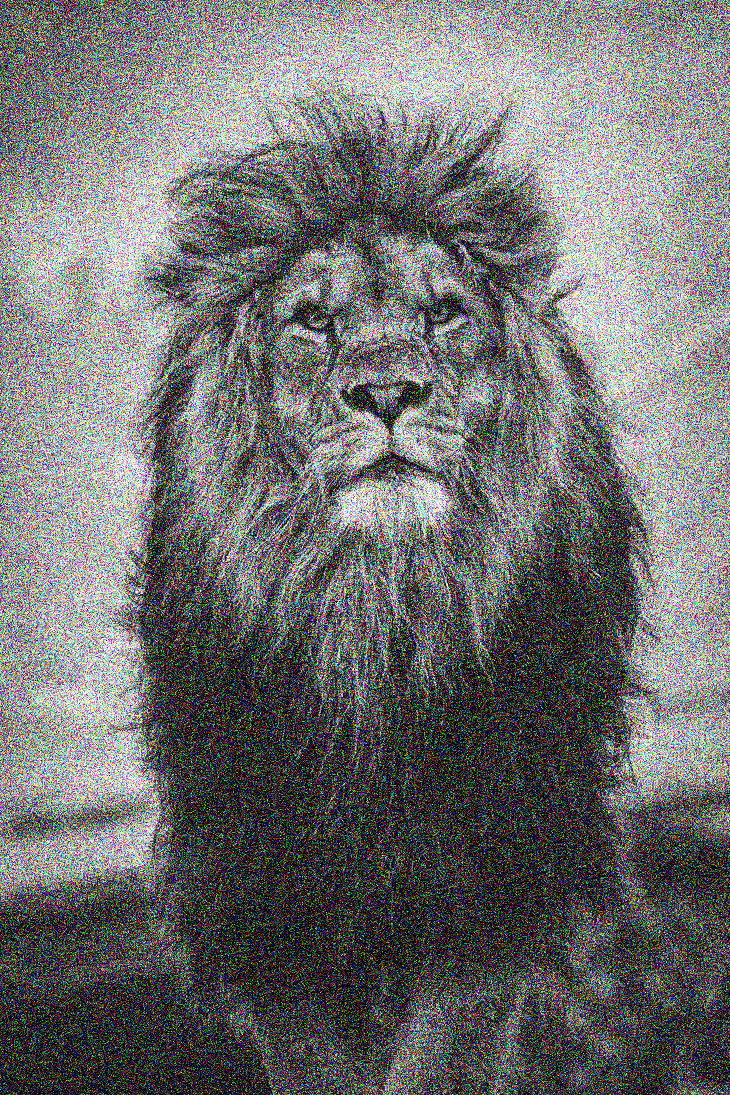

epoch : 0
Step: 0
Progression : 20.0%
SHAPE FEATURES CONTENT (1, 68, 45, 512)


KeyboardInterrupt: 

In [126]:
final_img = NST.transfert_style(1, 5)